In [1]:
import cudf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

****Prepare Dataset****

In [2]:
%%time 
transactions = cudf.read_csv('storage/transactions_train.csv')
articles = cudf.read_csv('storage/articles.csv')
customers = cudf.read_csv('storage/customers.csv')

CPU times: user 1.2 s, sys: 1.75 s, total: 2.94 s
Wall time: 6.98 s


In [3]:
transactions['t_dat'] = cudf.to_datetime(transactions['t_dat'])
transactions

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2
...,...,...,...,...,...
31788319,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,929511001,0.059305,2
31788320,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,891322004,0.042356,2
31788321,2020-09-22,fff380805474b287b05cb2a7507b9a013482f7dd0bce0e...,918325001,0.043203,1
31788322,2020-09-22,fff4d3a8b1f3b60af93e78c30a7cb4cf75edaf2590d3e5...,833459002,0.006763,1


****Maximum duration between customers****

In [5]:
%%time
transactions['t_dat'] = cudf.to_datetime(transactions['t_dat'])
transactions['days'] = transactions['t_dat'] - transactions['t_dat'].min()
transactions['days'] = transactions['days'].dt.days

CPU times: user 3.83 ms, sys: 1.94 ms, total: 5.77 ms
Wall time: 5.16 ms


In [38]:
%%time
tmp = transactions.groupby('customer_id')['days'].unique().to_pandas()

CPU times: user 981 ms, sys: 494 ms, total: 1.47 s
Wall time: 1.47 s


In [94]:
max_duration_between_purchase = tmp.apply(lambda x: np.diff(x).max() if len(x) > 1 else 0)
min_duration_between_purchase = tmp.apply(lambda x: np.diff(x).min() if len(x) > 1 else 0)

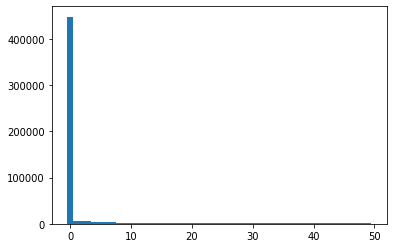

In [52]:
_ = plt.hist(max_duration_between_purchase,bins=50,range=(-0.5,49.5))

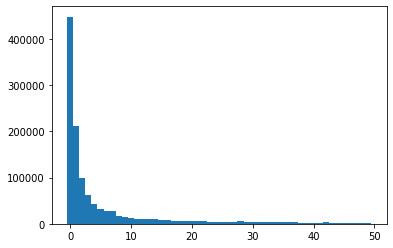

In [95]:
_ = plt.hist(min_duration_between_purchase,bins=50,range=(-0.5,49.5))

****Number of purchase for each customer****

In [61]:
number_of_purchase = transactions.groupby('customer_id')['article_id'].count().to_pandas()

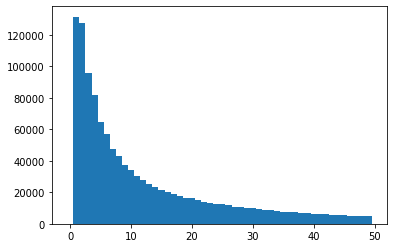

In [62]:
_ = plt.hist(number_of_purchase,bins=50,range=(-0.5,49.5))

****Mean number of purchase vs max duration between purchase****

In [89]:
plt_df = max_duration_between_purchase.to_frame().merge(number_of_purchase.to_frame(),on='customer_id',how='left')

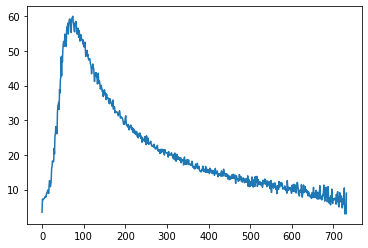

In [90]:
plt.plot(np.sort(plt_df['days'].unique()),plt_df.groupby('days')['article_id'].mean())

****Mean number of purchase vs max duration between purchase****

In [96]:
plt_df = min_duration_between_purchase.to_frame().merge(number_of_purchase.to_frame(),on='customer_id',how='left')

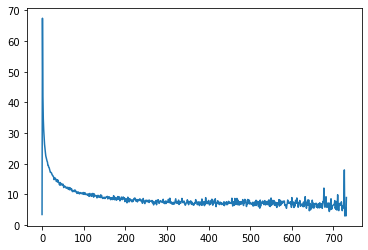

In [97]:
plt.plot(np.sort(plt_df['days'].unique()),plt_df.groupby('days')['article_id'].mean())

****Total number of purchase vs max duration between purchase****

In [100]:
plt_df = max_duration_between_purchase.to_frame().merge(number_of_purchase.to_frame(),on='customer_id',how='left')

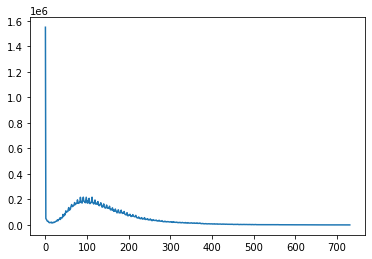

In [101]:
_ = plt.plot(np.sort(plt_df['days'].unique()),plt_df.groupby('days')['article_id'].sum())

****Mean number of activity vs max duration between purchase****

In [107]:
number_of_activity = transactions.groupby('customer_id')['t_dat'].unique().to_pandas()
number_of_activity = number_of_activity.apply(len)

In [109]:
plt_df = max_duration_between_purchase.to_frame().merge(number_of_activity.to_frame(),on='customer_id',how='left')

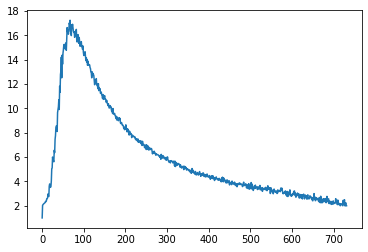

In [114]:
_ = plt.plot(np.sort(plt_df['days'].unique()),plt_df.groupby('days')['t_dat'].mean())

****Total number of activity vs max duration between purchase****

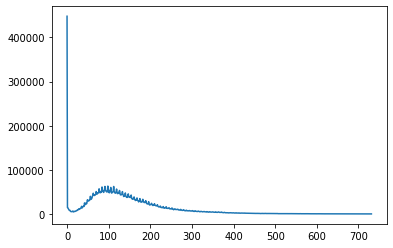

In [122]:
_ = plt.plot(np.sort(plt_df['days'].unique()),plt_df.groupby('days')['t_dat'].sum())

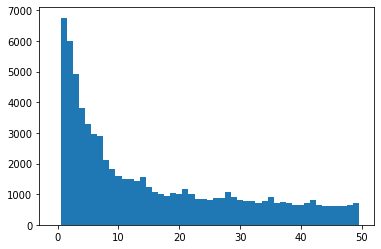

In [149]:
_ = plt.hist(plt_df[plt_df['t_dat']==2]['days'],bins=50,range=(-0.5,49.5))

****Customer overlap****

In [12]:
test_transactions = transactions[(transactions.t_dat>cudf.to_datetime('2019-09-07'))&(transactions.t_dat<=cudf.to_datetime('2019-09-15'))].to_pandas()
tmp2 = test_transactions['customer_id'].unique().tolist()

In [13]:
test_transactions = transactions[(transactions.t_dat>cudf.to_datetime('2019-09-15'))&(transactions.t_dat<=cudf.to_datetime('2019-09-22'))].to_pandas()
tmp1 = test_transactions['customer_id'].unique().tolist()

In [14]:
len(tmp1),len(tmp2)

(64877, 75286)

In [15]:
tmp3 = list(set(tmp2).intersection(tmp1))

In [16]:
len(tmp3) / len(tmp1) , len(tmp3) / len(tmp2) 

(0.19581669929250736, 0.16874319262545492)